# Product Force - The Variant Bunch
February 22nd 2019

Lets readf in a ClinVar download, plot some histograms.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import json

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Extract genes column.   Some show multiple genes/locations - e.g. "CFTR|LOC11167447".  For now, just take the fires

def extract_first_genes(df_):
    """ Return a list of genes, extracting only one (the first one) per row """
    nrows, ncolumns = df_.shape
    all_genes = df_['Gene(s)']
    pruned_genes = [g.split('|')[0] for g in all_genes]
    assert len(pruned_genes) == nrows
    return pruned_genes

def test_extract_first_genes():
    data = {'Gene(s)': ['GRN|LOC1234', 'CFTR'],
            'Review Status':['None', 'None']}
    df = pd.DataFrame(data)
    genes = extract_first_genes(df)
    print(genes)
    assert len(genes) == 2
    print("test_extract_first_genes: passed.")
    
test_extract_first_genes()

['GRN', 'CFTR']
test_extract_first_genes: passed.


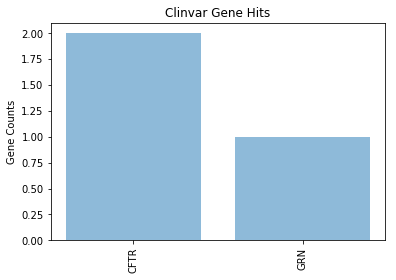

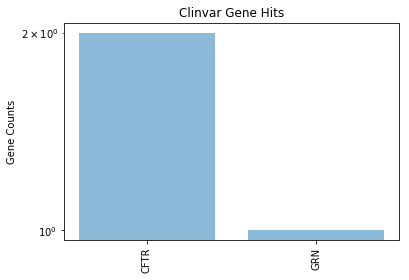

In [4]:
def plot_gene_histogram(genes, logorlinear='linear'):
    """ Given a list of gene names, plot a histogram of gene counts"""
    assert logorlinear in ('log', 'linear')
    gene_counts = Counter(genes)
    gene_names = gene_counts.keys()
    counts = gene_counts.values()
    bar_pos = np.arange(len(gene_names))

    plt.bar(gene_names, counts, align='center', alpha=0.5)
    plt.xticks(bar_pos, gene_names)
    plt.ylabel('Gene Counts')
    plt.xticks(rotation='vertical')
    plt.yscale(logorlinear)
    plt.title('Clinvar Gene Hits')
    plt.show()
    
def test_plot_gene_histogram():
    test_genes = ["GRN", "CFTR", "CFTR"]
    plot_gene_histogram(test_genes)
    plot_gene_histogram(test_genes, 'log')
    
    
test_plot_gene_histogram()

In [5]:
def thing_hist_as_json(thing_list):
    """ Return a count histogram in a json format suitable for passing to Alison's front end.  Thing list is e.g.
    a list of names """
    counts = Counter(thing_list)
    jslist = [{'name':key, 'value':counts[key]} for key in counts.keys()]
    return json.dumps(jslist, indent=4, sort_keys=True)
    
def test_thing_hist_as_json():
    test_genes = ["GRN", "CFTR", "CFTR"]
    json = thing_hist_as_json(test_genes)
    print(json)
    
test_thing_hist_as_json()   

[
    {
        "name": "CFTR",
        "value": 2
    },
    {
        "name": "GRN",
        "value": 1
    }
]


Loading clinvar spreadsheet...


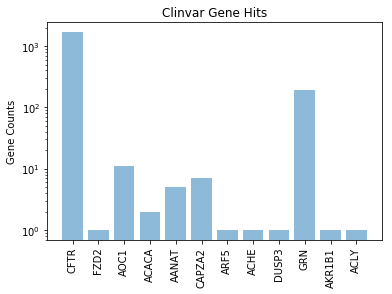

[
    {
        "name": "CFTR",
        "value": 1673
    },
    {
        "name": "FZD2",
        "value": 1
    },
    {
        "name": "AOC1",
        "value": 11
    },
    {
        "name": "ACACA",
        "value": 2
    },
    {
        "name": "AANAT",
        "value": 5
    },
    {
        "name": "CAPZA2",
        "value": 7
    },
    {
        "name": "ARF5",
        "value": 1
    },
    {
        "name": "ACHE",
        "value": 1
    },
    {
        "name": "DUSP3",
        "value": 1
    },
    {
        "name": "GRN",
        "value": 190
    },
    {
        "name": "AKR1B1",
        "value": 1
    },
    {
        "name": "ACLY",
        "value": 1
    }
]


In [6]:
def main():
    print("Loading clinvar spreadsheet...")
    download_fname = 'clinvar_GRN_OR_CFTR.txt'
    df = pd.read_csv(download_fname, sep='\t')
    df.describe(include='all')
    
    genes = extract_first_genes(df)
    
    plot_gene_histogram(genes, 'log')
    
    json = thing_hist_as_json(genes)
    print(json)

main()